In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel # Feature selector
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import recall_score, confusion_matrix 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import feature_selection
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df = pd.read_csv('Challenge_LATAM/custom_df.csv')
df.head(3)

,Unnamed: 0,DIA,MES,DIANOM,dif_min,atraso_15,temporada_alta,periodo_dia,cambio_aerolinea,cambio_num_vuelo,...,SIGLADES_Montevideo,SIGLADES_Nueva York,SIGLADES_Other,SIGLADES_Paris,SIGLADES_Puerto Montt,SIGLADES_Punta Arenas,SIGLADES_Rio de Janeiro,SIGLADES_Sao Paulo,SIGLADES_Temuco,SIGLADES_Valdivia
0,0,1,1,6,3.0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,0,9.0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3,1,1,9.0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def dropcol(df,cols):
        return df.drop(cols, axis = 1, inplace = True)
dropcol(df,'Unnamed: 0')

Preparamos el dataset para el modelo

In [4]:
y = df['atraso_15']
X = df.drop(['atraso_15', 'dif_min'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=20, stratify=y)
# stratify = y because it's an imbalanced dataset

#### Métrica utilizada

Para determinar cuál es el modelo que mejor performa, hemos elegido la métrica de recall. 

$$ Recall\: \frac{TP}{TP + FN } $$

El recall se centra en los True Positives - es decir, se utiliza para saber cuantos Verdaderos Positivos son correctamente clasificados por el modelo. 
En nuestro caso, es más importante que el modelo identifique como vuelos atrasados todos los vuelos que realmente se han atrasado, ya que entendemos que los FN (predecir vuelo como no atrasado cuando en realidad es atrasado) puede tener un impacto negativo en el cliente. 

## Modelos de Clasificación
#### 1. Random Forest
Usamos class_weight = 'balanced' ya que se trata de un imbalanced dataset.

In [20]:
# Random Forest
rf_pipe = Pipeline([('scl', StandardScaler()),
                ('clf', RandomForestClassifier(class_weight='balanced', random_state = 42)),
                        ])
                        
param_range = [3, 4, 5, 6, 7, 8, 9, 10, 11]
param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1, 0.01]


grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range}]

n_jobs = -1 #n_jobs to run faster
skf = StratifiedKFold(n_splits=10)

# Randomized Search
gs_rf = RandomizedSearchCV(estimator= rf_pipe, 
                           param_distributions=grid_params_rf, 
                           scoring = "recall",
                           cv= skf) 

gs_rf.fit(X_train, y_train)

print('Best params: %s' % gs_rf.best_params_)
# Best training recall Score
print('Best training recall Score: %.3f' % gs_rf.best_score_)
# Predict on test data with best params
y_pred = gs_rf.predict(X_test)
# Test data recall of model with best params
print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))

Best params: {'clf__min_samples_split': 4, 'clf__min_samples_leaf': 9, 'clf__max_depth': 8, 'clf__criterion': 'gini'}
Best training recall Score: 0.676
Test set recall score for best params: 0.676 


Feature importance of Random Forest with best parameters:

In [21]:
rfc = Pipeline([('scl', StandardScaler()),
                ('clf', RandomForestClassifier(class_weight='balanced',min_samples_split= 4,min_samples_leaf=9, max_depth=8, criterion='gini', random_state=42)),
                        ])

rfc.fit(X, y)

y_pred = rfc.predict(X_test)

recall_score(y_test, y_pred)

0.7003171247357294

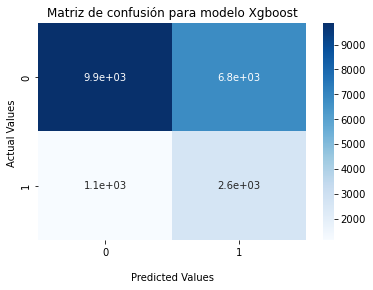

In [22]:
#Veamos la matriz de confusión
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión para modelo Xgboost');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

#### 2. Ranfom Forest Feature Selection 

#### 3. XGBoost

#### 4. SVM - Support Vector Machine